In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import mean_squared_error

df_r_all = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
df_r_all.date = pd.to_datetime(df_r_all.date)

In [40]:

df2020 = pd.read_csv("Region_Mobility_Report_CSVs/2020_DE_Region_Mobility_Report.csv")

df2021 = pd.read_csv("Region_Mobility_Report_CSVs/2021_DE_Region_Mobility_Report.csv")

df2022 = pd.read_csv("Region_Mobility_Report_CSVs/2022_DE_Region_Mobility_Report.csv")

#df2023 = pd.read_csv("Region_Mobility_Report_CSVs/2023_DE_Region_Mobility_Report.csv")

df = pd.concat([df2020,df2021,df2022])

df_apple= pd.read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/apple_mobility_report.csv")
#df_apple_uk = pd.read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/apple_mobility_report.csv")

df_apple.date = pd.to_datetime(df_apple.date)
df.date = pd.to_datetime(df.date)


In [42]:
set(df_apple.country)

{'Albania',
 'Argentina',
 'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Bulgaria',
 'Cambodia',
 'Canada',
 'Chile',
 'Colombia',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Macao',
 'Malaysia',
 'Mexico',
 'Morocco',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Philippines',
 'Poland',
 'Portugal',
 'Republic of Korea',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay',
 'Vietnam'}

In [4]:
df_apple_ge = df_apple[df_apple['country']=="Germany"][df_apple['sub-region']=="Total"].set_index("date")


features_apple =  ['driving','transit','walking']
df_apple_ge=df_apple_ge[features_apple]
features = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']
df_Ger = df[df["sub_region_1"].isnull()].set_index('date')[features]

df2 = pd.read_csv("epidemic_prognosis/_output/cx_from_steven.csv")
df2.day = pd.to_datetime(df2.day)



df = df_Ger.join(df2.set_index("day")).rolling(7).sum().multiply(1/7).shift(-3).dropna()

df_a = df_apple_ge.join(df2.set_index("day")).rolling(7).sum().multiply(1/7).shift(-3).dropna()

df = df.join(df_apple_ge).dropna()

#df = (df-df.shift(-1)).dropna()

import xgboost as xgb
dtrain = xgb.DMatrix(df[features+features_apple][:700], label=df['cx'][:700])
dtest_reg = xgb.DMatrix(df[features+features_apple])

# Define hyperparameters

params = {"objective": "reg:squarederror", "tree_method": "hist"} #,"booster":"gblinear" }
 #,"booster":"gblinear" 

n = 20
model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [91]:
def predict_ctr(ctr_sh,ctr_ln,R=True,bis="2021-01-31"):
    df2020_c = pd.read_csv("Region_Mobility_Report_CSVs/2020_"+ctr_sh+"_Region_Mobility_Report.csv")
    df2021_c = pd.read_csv("Region_Mobility_Report_CSVs/2021_"+ctr_sh+"_Region_Mobility_Report.csv")
    df2022_c = pd.read_csv("Region_Mobility_Report_CSVs/2022_"+ctr_sh+"_Region_Mobility_Report.csv")

    df_c = pd.concat([df2020_c,df2021_c,df2022_c])
    df_c.date = pd.to_datetime(df_c.date)

    df_apple_c = df_apple[df_apple['country']==ctr_ln][df_apple['sub-region']=="Total"].set_index("date")
    df_apple_c=df_apple_c[features_apple]

    df_c = df_c[df_c["sub_region_1"].isnull()].set_index('date')[features]

    df_r = df_r_all[df_r_all.location==ctr_ln][['date','reproduction_rate']].set_index('date').dropna()

    df_c = df_c.join(df_apple_c).dropna()
    df_c = df_c.join(df_r).dropna()

    dtest_reg = xgb.DMatrix(df_c[features+features_apple])

    preds = model.predict(dtest_reg)
    #preds = regr.predict(df[features+features_apple])

    df_c['preds'] = preds
    #df.cx.rolling(7).sum().multiply(1/7).shift(-3).plot(linewidth= 0.5,marker=".")
    plt.figure()
    df_c.preds.rolling(7).sum().multiply(1/7).shift(-3).plot(label="Contact Index",linewidth=2)
    #df_a[features_apple[2]].plot()
    top = max(df_c.preds.rolling(7).sum().multiply(1/7)["2020-05-01":bis])
    bot = min(df_c.preds.rolling(7).sum().multiply(1/7)["2020-05-01":bis])
    plt.ylim(0.5*bot,1.1*top)
    plt.xlim("2020-03-01",bis)
    plt.ylabel("Contact Index")
    plt.title = ctr_ln
    ax=plt.gca()
    
    if R:
    #ax2.add_patch(Rectangle((50, 15), 1, 55,alpha=0.5))
    #ax2.add_patch(Rectangle((304, 15), 1, 55,alpha=0.5))

    #plt.scatter(["2020-11-05"]*50,np.arange(20,50,30./50),color="k",s=1)
    #plt.scatter(["2021-01-06"]*50,np.arange(20,50,30./50),color="k",s=1)

        ax2 = df_c.reproduction_rate.plot(secondary_y=True,label="effective R",linestyle = "--")
        top = max(df_c.reproduction_rate["2020-05-01":"2020-12-31"])
        bot = min(df_c.reproduction_rate["2020-05-01":"2020-12-31"])
        plt.ylim(0.9*bot,1.1*top)

        lines = ax.get_lines() + ax.right_ax.get_lines()
        ax.legend(lines,["CX","effective R"],loc=1)
    else:
        plt.legend(loc=1)
    ax.set_title(ctr_ln)

    #plt.plot([20,100],[50,100])
    plt.ylabel("Effective R")
 #   plt.close()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


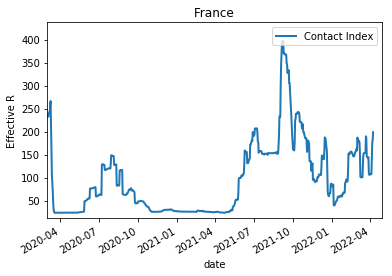

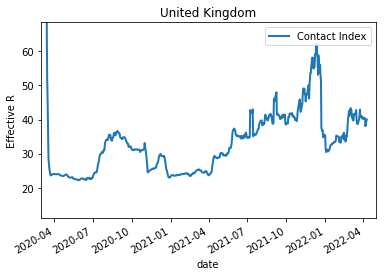

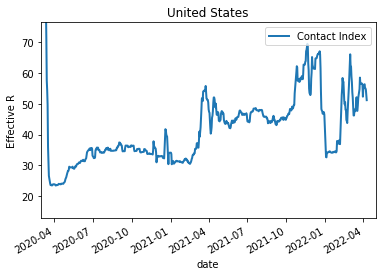

In [93]:
ctrs = { "FR": "France", "GB": "United Kingdom","US": "United States",
       "IT": "Italy"}

#fig, axs = plt.subplots(2)
#i=0
for ctr_sh in ctrs:    
    ctr_ln = ctrs[ctr_sh]
    predict_ctr(ctr_sh,ctr_ln,False,"2022-04-30")


In [94]:
plt.scatter(df_uk["2020-05-01":"2020-12-31"].preds,df_uk["2020-05-01":"2020-12-31"].shift(-15).reproduction_rate)

NameError: name 'df_uk' is not defined

In [ ]:
df_uk.reproduction_rate.shift(-20)/lin_reg(df_uk.preds)

In [267]:
df.iloc[304]

retail_and_recreation_percent_change_from_baseline   -53.285714
grocery_and_pharmacy_percent_change_from_baseline      2.428571
parks_percent_change_from_baseline                    -7.000000
transit_stations_percent_change_from_baseline        -46.428571
workplaces_percent_change_from_baseline              -35.714286
residential_percent_change_from_baseline              13.714286
cx                                                    26.774513
driving                                              -36.180000
transit                                              -36.510000
walking                                              -40.010000
Name: 2020-12-20, dtype: float64

In [210]:
features

['retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline']